# Timeline Extraction from Video

This notebook implements timeline extraction functionality based on the camera and HSV analysis components from the deposition-detection project.

## Features
- Load video files (mp4 or AVI)
- Automatic ellipse detection or manual ellipse definition
- HSV data extraction and visualization
- Toggle for first/second derivatives with smoothing
- Optional CSV export

## Setup

In [1]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
from dataclasses import dataclass, field
import datetime
import os

# Enable inline plotting
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


In [24]:
# Ellipse detection parameters
ELLIPSE_DETECTION_CONFIG = {
    'canny_threshold1': 50,      # Lower threshold for Canny edge detection
    'canny_threshold2': 150,     # Upper threshold for Canny edge detection
    'min_contour_length_ratio': 0.4,  # Minimum contour length as ratio of frame width
    'max_contour_length_ratio': 3.0,  # Maximum contour length as ratio of frame width
    'min_aspect_ratio': 0.5,     # Minimum aspect ratio for ellipse
    'ellipse_margin': 0.1        # Margin to shrink ellipse for robust masking (0.1 = 10% smaller)
}

## Core Classes and Functions

In [37]:
@dataclass
class HSVStats:
    h_m: float = 0.0  # Raw values
    s_m: float = 0.0
    v_m: float = 0.0
    h_decay: float = 0.0  # Smooth values
    s_decay: float = 0.0
    v_decay: float = 0.0
    dh: float = 0.0  # First derivatives
    ds: float = 0.0
    dv: float = 0.0
    ddh: float = 0.0  # Second derivatives
    dds: float = 0.0
    ddv: float = 0.0


class ImageProcessor:
    def __init__(self, config=None):
        self.config = config or ELLIPSE_DETECTION_CONFIG
        self.ellipse_margin = self.config['ellipse_margin']
    
    @staticmethod
    def to_hsv(frame):
        return cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    @staticmethod
    def get_hsv_stats(hsv_frame, mask=None):
        """Calculate HSV statistics, optionally using a mask"""
        h, s, v = cv2.split(hsv_frame)
        
        if mask is not None:
            h_mean = np.mean(h[mask > 0])
            s_mean = np.mean(s[mask > 0])
            v_mean = np.mean(v[mask > 0])
        else:
            h_mean = np.mean(h)
            s_mean = np.mean(s)
            v_mean = np.mean(v)
            
        return {
            'h_m': h_mean,
            's_m': s_mean,
            'v_m': v_mean,
        }
    
    def detect_ellipse(self, frame):
        """Find the most prominent ellipse in the image.
        Returns ellipse parameters if found, or None if no suitable ellipse is found."""
        
        # Convert to grayscale if needed
        if len(frame.shape) == 3:
            bw = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            bw = frame.copy()
            
        # Normalize intensity
        p2, p98 = np.percentile(bw, (2, 98))
        bw = cv2.normalize(bw, None, p2, p98, cv2.NORM_MINMAX)
        
        # Edge detection
        edges = cv2.Canny(bw, 
                         self.config['canny_threshold1'], 
                         self.config['canny_threshold2'])
        
        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        width = frame.shape[1]
        best_ellipse = None
        best_score = 0
        
        # Iterate through all possible ellipses and find the one with the highest score
        for contour in contours:
            contour_length = cv2.arcLength(contour, False)
            
            # Skip if contour is too small or too large
            min_length = self.config['min_contour_length_ratio'] * width
            max_length = self.config['max_contour_length_ratio'] * width
            if contour_length < min_length or contour_length > max_length:
                continue
                
            # Need at least 5 points to fit an ellipse
            if len(contour) < 5:
                continue
                
            try:
                ellipse = cv2.fitEllipse(contour)
            except cv2.error:
                continue
                
            # Skip ellipses with too narrow aspect ratio
            aspect_ratio = ellipse[1][0] / ellipse[1][1]
            if aspect_ratio < self.config['min_aspect_ratio']:
                continue
                
            # Compute a center-weighted score
            frame_center = (frame.shape[1] // 2, frame.shape[0] // 2)
            distance_from_center = np.sqrt((ellipse[0][0] - frame_center[0])**2 +
                                           (ellipse[0][1] - frame_center[1])**2)
            center_weight = 1 - (distance_from_center /
                                 (0.5 * np.sqrt(frame.shape[1]**2 + frame.shape[0]**2)))
            
            # Score based on size, aspect ratio, and center position
            score = contour_length * (1 - abs(1 - aspect_ratio)) * center_weight
            
            if score > best_score:
                best_score = score
                best_ellipse = ellipse
        
        return best_ellipse
    
    def create_ellipse_mask(self, frame, ellipse):
        """Create an ellipse mask from ellipse parameters"""
        mask = np.zeros(frame.shape[:2], dtype=np.uint8)
        
        # Create inner ellipse for more robust masking
        inner_ellipse = (
            ellipse[0],
            ((1 - self.ellipse_margin) * ellipse[1][0],
             (1 - self.ellipse_margin) * ellipse[1][1]),
            ellipse[2]
        )
        
        cv2.ellipse(mask, inner_ellipse, 255, -1)
        return mask, inner_ellipse
    
    def create_manual_ellipse_mask(self, frame, center, axes, angle):
        """Create an ellipse mask from manual parameters"""
        ellipse = (center, axes, angle)
        return self.create_ellipse_mask(frame, ellipse)


class HSVAnalyzer:
    def __init__(self, processor: ImageProcessor, decay_alpha=0.05):
        self.processor = processor
        self.hsv_history = []
        self.ref_stats = None
        self.current_mask = None
        self.current_ellipse = None
        self.decay_alpha = decay_alpha
        self.derivative_smoothing = False
        self.smoothing_window_size = 5
        
    def set_derivative_smoothing(self, enable: bool, window_size: int = 5):
        """Enable/disable derivative smoothing and set window size"""
        self.derivative_smoothing = enable
        self.smoothing_window_size = window_size

    def set_reference(self, frame, ellipse=None):
        """Set reference frame and ellipse mask"""
        hsv_frame = self.processor.to_hsv(frame)
        
        if ellipse is not None:
            self.current_mask, self.current_ellipse = self.processor.create_ellipse_mask(frame, ellipse)
        else:
            self.current_mask = None
            self.current_ellipse = None
        
        self.ref_stats = self.processor.get_hsv_stats(hsv_frame, self.current_mask)
        self.clear_history()
        
    def clear_history(self):
        """Clear all historical data"""
        self.hsv_history.clear()
        
    def update(self, frame):
        """Update with new frame relative to reference frame"""
        hsv_frame = self.processor.to_hsv(frame)
        hsv_stats = self.processor.get_hsv_stats(hsv_frame, self.current_mask)
        
        if self.ref_stats is None:
            self.ref_stats = hsv_stats

        # Calculate decay values with exponential smoothing
        if self.hsv_history:
            prev = self.hsv_history[-1]
            h_decay = self.decay_alpha * (hsv_stats['h_m'] - self.ref_stats['h_m']) + \
                     (1 - self.decay_alpha) * prev.h_decay
            s_decay = self.decay_alpha * (hsv_stats['s_m'] - self.ref_stats['s_m']) + \
                     (1 - self.decay_alpha) * prev.s_decay
            v_decay = self.decay_alpha * (hsv_stats['v_m'] - self.ref_stats['v_m']) + \
                     (1 - self.decay_alpha) * prev.v_decay
        else:
            h_decay = hsv_stats['h_m'] - self.ref_stats['h_m']
            s_decay = hsv_stats['s_m'] - self.ref_stats['s_m']
            v_decay = hsv_stats['v_m'] - self.ref_stats['v_m']
        
        # Calculate derivatives
        if self.hsv_history:
            prev = self.hsv_history[-1]
            dh = h_decay - prev.h_decay
            ds = s_decay - prev.s_decay
            dv = v_decay - prev.v_decay
            ddh = dh - prev.dh
            dds = ds - prev.ds
            ddv = dv - prev.dv
        else:
            dh = ds = dv = ddh = dds = ddv = 0.0

        relative_stats = HSVStats(
            h_m=hsv_stats['h_m'] - self.ref_stats['h_m'],
            s_m=hsv_stats['s_m'] - self.ref_stats['s_m'],
            v_m=hsv_stats['v_m'] - self.ref_stats['v_m'],
            h_decay=h_decay,
            s_decay=s_decay,
            v_decay=v_decay,
            dh=dh, ds=ds, dv=dv,
            ddh=ddh, dds=dds, ddv=ddv
        )
        
        self.hsv_history.append(relative_stats)
    
    def _apply_sliding_window_smoothing(self, data, window_size):
        """Apply sliding window smoothing to data"""
        if len(data) < window_size:
            return data
        
        data_array = np.array(data)
        kernel = np.ones(window_size) / window_size
        padded_data = np.pad(data_array, window_size//2, mode='edge')
        smoothed = np.convolve(padded_data, kernel, mode='valid')
        
        # Ensure output length matches input length
        return smoothed[:len(data)]
    
    def get_history(self):
        """Return history with optional derivative smoothing"""
        history = {
            'h_means': [stats.h_m for stats in self.hsv_history],
            's_means': [stats.s_m for stats in self.hsv_history],
            'v_means': [stats.v_m for stats in self.hsv_history],
            'h_decay': [stats.h_decay for stats in self.hsv_history],
            's_decay': [stats.s_decay for stats in self.hsv_history],
            'v_decay': [stats.v_decay for stats in self.hsv_history],
            'dH': [stats.dh for stats in self.hsv_history],
            'dS': [stats.ds for stats in self.hsv_history],
            'dV': [stats.dv for stats in self.hsv_history],
            'ddH': [stats.ddh for stats in self.hsv_history],
            'ddS': [stats.dds for stats in self.hsv_history],
            'ddV': [stats.ddv for stats in self.hsv_history]
        }
        
        if self.derivative_smoothing and len(self.hsv_history) > 0:
            # Smooth decay values
            history['h_decay'] = self._apply_sliding_window_smoothing(
                history['h_decay'], self.smoothing_window_size)
            history['s_decay'] = self._apply_sliding_window_smoothing(
                history['s_decay'], self.smoothing_window_size)
            history['v_decay'] = self._apply_sliding_window_smoothing(
                history['v_decay'], self.smoothing_window_size)
            
            # Smooth first derivatives
            history['dH'] = self._apply_sliding_window_smoothing(
                history['dH'], self.smoothing_window_size * 2)
            history['dS'] = self._apply_sliding_window_smoothing(
                history['dS'], self.smoothing_window_size * 2)
            history['dV'] = self._apply_sliding_window_smoothing(
                history['dV'], self.smoothing_window_size * 2)
            
            # Smooth second derivatives
            history['ddH'] = self._apply_sliding_window_smoothing(
                history['ddH'], self.smoothing_window_size * 4)
            history['ddS'] = self._apply_sliding_window_smoothing(
                history['ddS'], self.smoothing_window_size * 4)
            history['ddV'] = self._apply_sliding_window_smoothing(
                history['ddV'], self.smoothing_window_size * 4)
        
        return history



## Video Processing and Visualization Functions

In [26]:
def load_video(video_path):
    """Load video and return video capture object"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")
    return cap


def process_video_frames(cap, analyzer, max_frames=None):
    """Process video frames and collect HSV data"""
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        analyzer.update(frame)
        frame_count += 1
        
        if max_frames and frame_count >= max_frames:
            break
        
        if frame_count % 100 == 0:
            print(f"Processed {frame_count} frames...")
    
    cap.release()
    return frame_count


def plot_timeline(history, derivative_order=1, title_suffix=""):
    """Plot the timeline data"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sample_indices = list(range(len(history['h_means'])))
    
    if derivative_order == 0:
        ax.plot(sample_indices, history['h_means'], label='Hue (Raw)', alpha=0.7)
        ax.plot(sample_indices, history['s_means'], label='Saturation (Raw)', alpha=0.7)
        ax.plot(sample_indices, history['v_means'], label='Value (Raw)', alpha=0.7)
        ax.set_title(f'Raw HSV Values Over Time{title_suffix}')
    elif derivative_order == 1:
        ax.plot(sample_indices, history['dH'], label='dH/dt', alpha=0.7)
        ax.plot(sample_indices, history['dS'], label='dS/dt', alpha=0.7)
        ax.plot(sample_indices, history['dV'], label='dV/dt', alpha=0.7)
        ax.set_title(f'First Derivatives of HSV Values{title_suffix}')
    else:
        ax.plot(sample_indices, history['ddH'], label='d²H/dt²', alpha=0.7)
        ax.plot(sample_indices, history['ddS'], label='d²S/dt²', alpha=0.7)
        ax.plot(sample_indices, history['ddV'], label='d²V/dt²', alpha=0.7)
        ax.set_title(f'Second Derivatives of HSV Values{title_suffix}')
    
    ax.set_xlabel('Frame Number')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    max_samples = len(sample_indices)
    tick_interval = max(1, max_samples // 10)
    ax.set_xticks(range(0, max_samples, tick_interval))
    
    plt.tight_layout()
    return fig, ax


def save_to_csv(history, filename):
    """Save history data to CSV file"""
    df = pd.DataFrame(history)
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")


def visualize_ellipse_on_frame(frame, ellipse, mask=None):
    """Visualize detected ellipse on frame"""
    fig, axes = plt.subplots(1, 2 if mask is not None else 1, figsize=(12, 6))
    
    if mask is None:
        axes = [axes]
    
    # Draw ellipse on frame
    frame_with_ellipse = frame.copy()
    cv2.ellipse(frame_with_ellipse, ellipse, (0, 255, 0), 2)
    axes[0].imshow(cv2.cvtColor(frame_with_ellipse, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Frame with Detected Ellipse')
    axes[0].axis('off')
    
    # Show mask overlay if provided
    if mask is not None:
        overlay = frame.copy()
        overlay[mask > 0] = [0, 255, 0]
        axes[1].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        axes[1].set_title('Mask Overlay')
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f'Ellipse: Center={ellipse[0]}, Axes={ellipse[1]}, Angle={ellipse[2]:.1f}°')



## Configuration and Video Loading

In [69]:
# Change this to your video file path
VIDEO_PATH = r"C:\CASUS\deposition_datasets\MoS2_no_rotation_complete film_MoS2-IDS-LS-001.mp4"  

# Load video
cap = load_video(VIDEO_PATH)

# Get first frame for reference
ret, first_frame = cap.read()
if not ret:
    raise ValueError('Could not read first frame from video')

print(f'Video loaded successfully. Frame dimensions: {first_frame.shape} with {cap.get(cv2.CAP_PROP_FRAME_COUNT)} frames.')

Video loaded successfully. Frame dimensions: (1080, 1080, 3) with 5018.0 frames.


## Ellipse Detection and Visualization


Using manual ellipse definition:
  Center: (500, 500)
  Axes: (850, 850)
  Angle: 0°

Visualizing detected region:


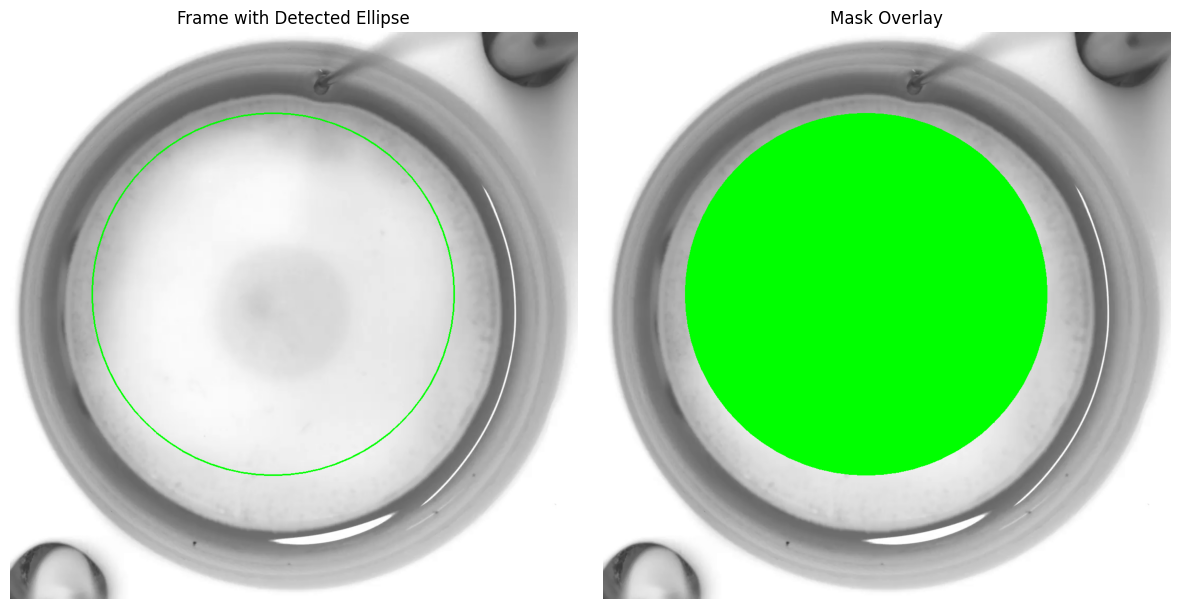

Ellipse: Center=(500, 500), Axes=(688.5, 688.5), Angle=0.0°


In [71]:
# Configuration
# Set to True to use manual ellipse definition instead of automatic detection
USE_MANUAL_ELLIPSE = True

# Manual ellipse parameters (only used if USE_MANUAL_ELLIPSE = True)
MANUAL_ELLIPSE_CENTER = (500, 500)  # (x, y)
MANUAL_ELLIPSE_AXES = (850, 850)     # (major_axis, minor_axis)
MANUAL_ELLIPSE_ANGLE = 0            # Angle in degrees

# Processing parameters
MAX_FRAMES = None  # Set to a number to limit processing, None for all frames
DECAY_ALPHA = 0.05  # Smoothing factor for HSV decay values

# Derivative smoothing
ENABLE_SMOOTHING = True
SMOOTHING_WINDOW_SIZE = 50

# Initialize processor and analyzer
processor = ImageProcessor(ELLIPSE_DETECTION_CONFIG)
analyzer = HSVAnalyzer(processor, decay_alpha=DECAY_ALPHA)

# Detect or use manual ellipse
if USE_MANUAL_ELLIPSE:
    print("\nUsing manual ellipse definition:")
    print(f"  Center: {MANUAL_ELLIPSE_CENTER}")
    print(f"  Axes: {MANUAL_ELLIPSE_AXES}")
    print(f"  Angle: {MANUAL_ELLIPSE_ANGLE}°")
    
    mask, ellipse = processor.create_manual_ellipse_mask(
        first_frame, MANUAL_ELLIPSE_CENTER, MANUAL_ELLIPSE_AXES, MANUAL_ELLIPSE_ANGLE)
    analyzer.set_reference(first_frame, ellipse)
else:
    print("\nDetecting ellipse automatically...")
    detected_ellipse = processor.detect_ellipse(first_frame)
    
    if detected_ellipse is None:
        print("⚠ No ellipse detected! Processing without mask.")
        analyzer.set_reference(first_frame)
    else:
        print("✓ Ellipse detected successfully")
        analyzer.set_reference(first_frame, detected_ellipse)

# Visualize ellipse
if analyzer.current_ellipse is not None:
    print("\nVisualizing detected region:")
    visualize_ellipse_on_frame(first_frame, analyzer.current_ellipse, analyzer.current_mask)


## Process Video Frames

In [72]:
print(f"\nProcessing video frames (max: {MAX_FRAMES or 'all'})...")
cap.release()
cap = load_video(VIDEO_PATH)
frame_count = process_video_frames(cap, analyzer, MAX_FRAMES)
print(f"✓ Processed {frame_count} frames")


Processing video frames (max: all)...
Processed 100 frames...
Processed 200 frames...
Processed 300 frames...
Processed 400 frames...
Processed 500 frames...
Processed 600 frames...
Processed 700 frames...
Processed 800 frames...
Processed 900 frames...
Processed 1000 frames...
Processed 1100 frames...
Processed 1200 frames...
Processed 1300 frames...
Processed 1400 frames...
Processed 1500 frames...
Processed 1600 frames...
Processed 1700 frames...
Processed 1800 frames...
Processed 1900 frames...
Processed 2000 frames...
Processed 2100 frames...
Processed 2200 frames...
Processed 2300 frames...
Processed 2400 frames...
Processed 2500 frames...
Processed 2600 frames...
Processed 2700 frames...
Processed 2800 frames...
Processed 2900 frames...
Processed 3000 frames...
Processed 3100 frames...
Processed 3200 frames...
Processed 3300 frames...
Processed 3400 frames...
Processed 3500 frames...
Processed 3600 frames...
Processed 3700 frames...
Processed 3800 frames...
Processed 3900 frame

In [73]:
# Apply smoothing if enabled
analyzer.set_derivative_smoothing(ENABLE_SMOOTHING, SMOOTHING_WINDOW_SIZE)
history = analyzer.get_history()
print(f"✓ Analysis complete (smoothing: {'enabled' if ENABLE_SMOOTHING else 'disabled'})")


✓ Analysis complete (smoothing: enabled)



Generating plots...


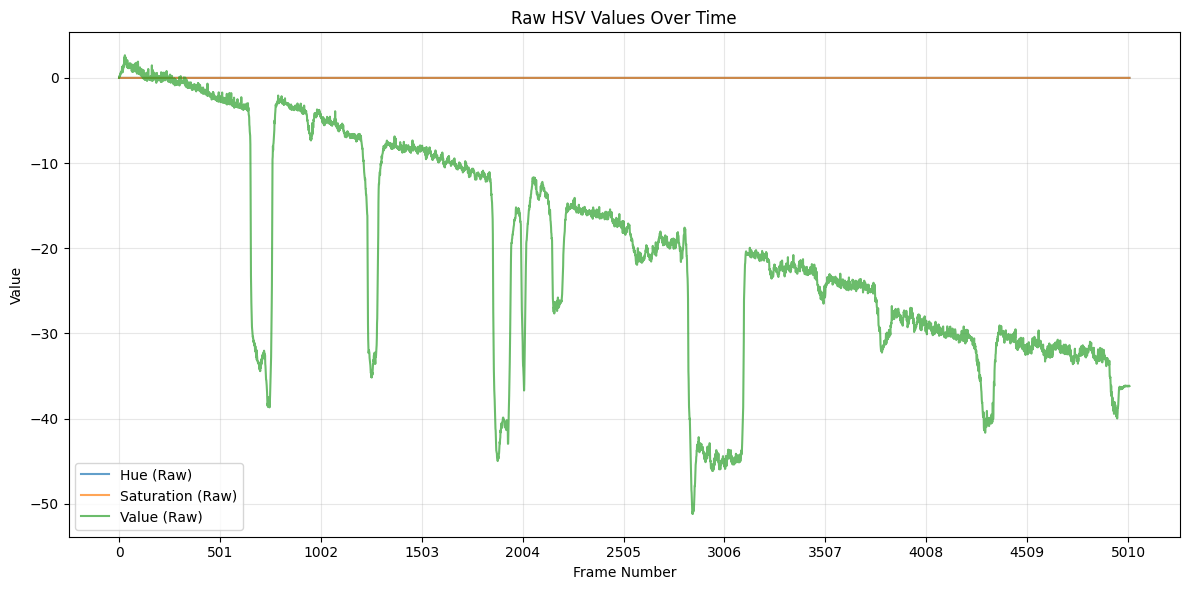

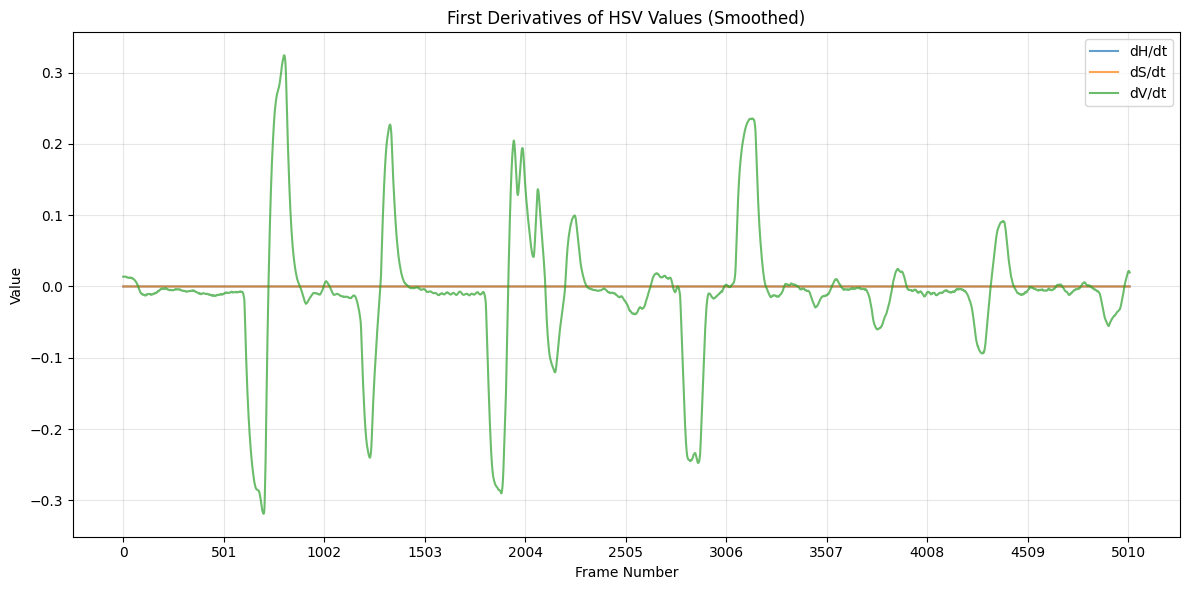

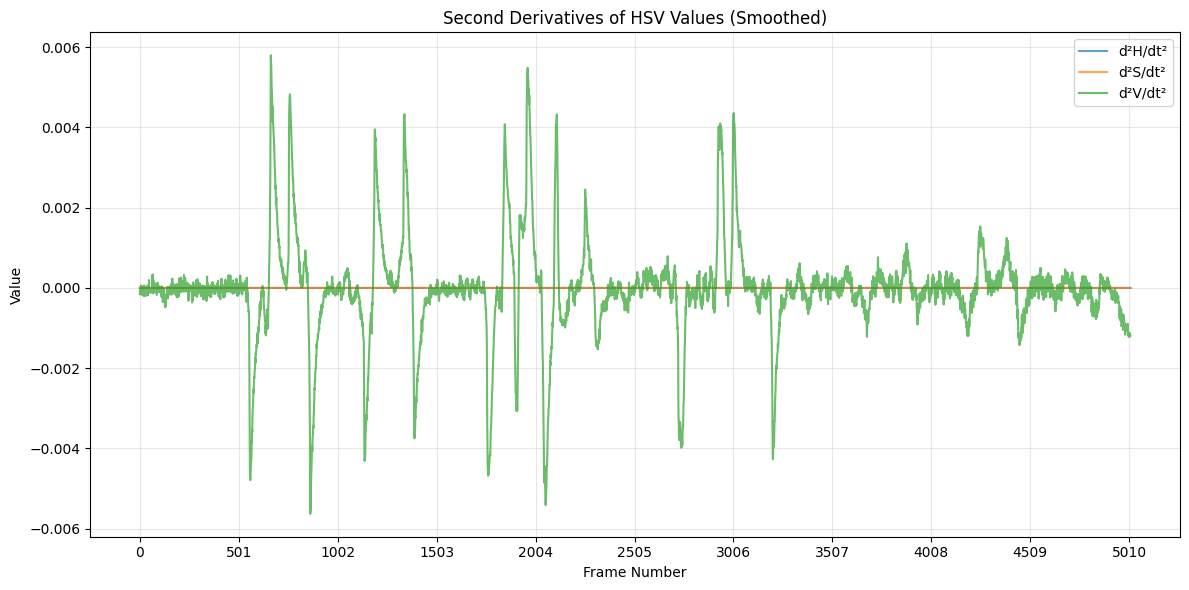

In [74]:
# Plot results
print("\nGenerating plots...")
plot_timeline(history, derivative_order=0)
plt.show()

plot_timeline(history, derivative_order=1, 
             title_suffix=" (Smoothed)" if ENABLE_SMOOTHING else "")
plt.show()

plot_timeline(history, derivative_order=2,
             title_suffix=" (Smoothed)" if ENABLE_SMOOTHING else "")
plt.show()


## Export Data to CSV

In [75]:
# Export to CSV
save_to_csv(history, 'timeline_data.csv')
print('CSV export complete!')

Data saved to timeline_data.csv
CSV export complete!
